# Importing Dependencies

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix # for measuring performance of classification
from sklearn.preprocessing import OneHotEncoder # for encoding labels to one hot array 
print(tf.__version__)

1.14.0


In [0]:
data=tf.keras.datasets.mnist #Importing Mnist Dataset to notebook
(trainX,trainY),(testX,testY)=data.load_data()
trainX=np.array([x.ravel() for x in trainX]) #unpacking all pixels of (28x28) image into a single 784 vector
testX=np.array([x.ravel() for x in testX]) #unpacking all pixels of (28x28) image into a single 784 vector
trainX=trainX/255.0 #Scaling down Values between 0 and 1 to converge fast to optimized value
testX=testX/255.0 #Scaling down Values between 0 and 1 to converge fast to optimized value
one_hot=OneHotEncoder(sparse=False)
trainY=one_hot.fit_transform(trainY.reshape(len(trainY),1)) #encoding labels to one hot vector
testY=one_hot.transform(testY.reshape(len(testY),1)) #encoding labels to one hot vector
print("Shape of Data: ")
print("Training Examles: ",trainX.shape)
print("Testing Examples: ",testX.shape)
img_size=(28,28)
pixels=784
num_of_classes=10
batch_size=1000

Shape of Data: 
Training Examles:  (60000, 784)
Testing Examples:  (10000, 784)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Helper Functions for plotting Images and loss graph

In [0]:
def plot_images(images, cls_true, cls_pred=None,w=3,h=3):
    assert len(images) == len(cls_true)==w*h
    fig, axes = plt.subplots(w, h)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_size), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [0]:
def plot_graph(data):
    plt.plot(data)
    plt.show()

# Plotting Images with true labels

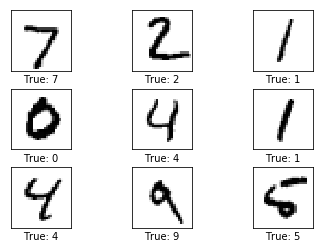

In [0]:
images=testX[0:9]
true_class=np.argmax(testY[0:9],axis=1)
plot_images(images,true_class)

# Defining model placeholders and variables

Number of Nodes
1. Input Layer=784 (?,784)
2. Hidden Layer 1 =512 (?,200)
3. Hidden Layer 3=128 (?,128)
4. Output Layer=10 (?,10)

In [0]:
layer1=pixels
layer2=512
layer3=128
layer4=num_of_classes
x=tf.placeholder(tf.float32,[None,layer1]) # Input Data
y=tf.placeholder(tf.float32,[None,num_of_classes]) # True Labels to comapare with predicted values by network and determine loss
#Hidden Layer 1
w1=tf.Variable(tf.truncated_normal([layer1, layer2], stddev=0.1))
b1=tf.Variable(tf.constant(0.1,shape=[1,layer2]))
#Hidden Layer 2
w2=tf.Variable(tf.truncated_normal([layer2, layer3], stddev=0.1))
b2=tf.Variable(tf.constant(0.1,shape=[1,layer3]))
#Output Layer
w3=tf.Variable(tf.truncated_normal([layer3, layer4], stddev=0.1))
b3=tf.Variable(tf.constant(0.1,shape=[1,layer4]))

## Calculation in layers and prediction

In [0]:
y1=tf.nn.relu(tf.matmul(x,w1)+b1)
y2=tf.nn.relu(tf.matmul(y1,w2)+b2)
y_pred=tf.matmul(y2,w3)+b3
prediction=tf.nn.softmax(y_pred)

## Defining Loss Function
Here Cross Entropy is used because it is better for classification problem. Also Tensorflow Function softmax_cross_entropy() is used which by default calculate softmax before finding cross entropy so no need to pass softmax applied vector to function. Also loss is taken as the mean of values we get from cross entropy.
Last two lines are used to find accuracy of model.

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=y_pred)
loss = tf.reduce_mean(cross_entropy)
accurate = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(accurate, tf.float32))

## Defining optimizer for model
In this case Gradient Descent is used.

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)

## Creating Session and Intializing variables

In [0]:
session=tf.Session()
session.run(tf.global_variables_initializer())

## Feed Dictionary to feed test data

In [0]:
feed_dict_test = {x: testX,y: testY}

## Print Accuracy of model and making Confusion matrix

In [0]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [0]:
def print_confusion_matrix():
    prediction = session.run(y_pred, feed_dict=feed_dict_test)
    cls_true=np.argmax(prediction,axis=1)
    cm = confusion_matrix(y_true=np.argmax(testY,axis=1),y_pred=cls_true)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_of_classes)
    plt.xticks(tick_marks, range(num_of_classes))
    plt.yticks(tick_marks, range(num_of_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Training Function

In [0]:
def train(iterations):
    cost=[]
    for i in range(iterations):
        rnd_index=np.random.choice(len(trainX),batch_size)
        x_batch=trainX[rnd_index]
        y_batch=trainY[rnd_index]
        train_dict={x:x_batch,y:y_batch}
        session.run(optimizer,feed_dict=train_dict)
        if i % batch_size == 0:
            minibatch_loss, minibatch_accuracy = session.run([loss, accuracy],feed_dict={x: x_batch, y: y_batch})
            print("Iteration",str(i),"\t| Loss =",str(minibatch_loss),"\t| Accuracy =",str(minibatch_accuracy))
            cost.append(minibatch_loss)
    return np.array(cost)

## Check Accuracy before training

In [0]:
print_accuracy()

Accuracy on test-set: 14.5%


## Training and plotting cost graph

Iteration 0 	| Loss = 2.814019 	| Accuracy = 0.192
Iteration 100 	| Loss = 0.14393848 	| Accuracy = 0.955
Iteration 200 	| Loss = 0.10942704 	| Accuracy = 0.966
Iteration 300 	| Loss = 0.08021873 	| Accuracy = 0.979
Iteration 400 	| Loss = 0.05665708 	| Accuracy = 0.987
Iteration 500 	| Loss = 0.040677488 	| Accuracy = 0.993
Iteration 600 	| Loss = 0.056773186 	| Accuracy = 0.989
Iteration 700 	| Loss = 0.03509536 	| Accuracy = 0.993
Iteration 800 	| Loss = 0.025830396 	| Accuracy = 0.995
Iteration 900 	| Loss = 0.019596523 	| Accuracy = 0.998


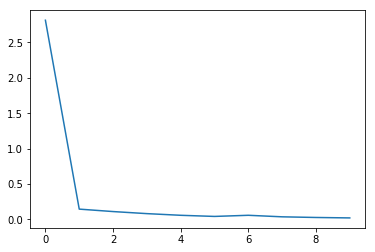

Accuracy on test-set: 97.6%


In [0]:
cost=train(1000)
plot_graph(cost)
print_accuracy()

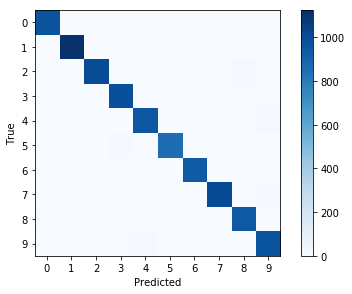

Accuracy on test-set: 97.6%


In [0]:
print_confusion_matrix()
print_accuracy()